# Data Science Project Workflow

## Project Overview
- **Objective**: The primary objectives of this project are:
1. To preprocess Sentinel-2 satellite images for land type classification.
2. To develop and implement a classification model (e.g., Random Forest, Convolutional Neural Networks) for identifying different land types (e.g., forest, urban areas, water bodies, agricultural land).
3. To evaluate the accuracy of the classification model using ground truth data.

- **Milestones**: Data Collection, Exploration, Preprocessing, Advanced Analysis, Model Development, Deployment, and Final Documentation.

---

# Team Information

## Team Members
- Ahmed Sayed Mohamed
- Sarah Khaled Mohamed
- Mahmoud Alaaeldin Mohammed
- Marwa Mansour Ali Hadhoud
- Mohamed Hassan Naseh


---

# Milestone 1: Data Collection, Exploration, and Preprocessing

## Data Collection
- Acquire a dataset from Kaggle ( https://www.kaggle.com/datasets/apollo2506/eurosat-dataset ).

In [ ]:
!pip install torch torchvision scikit-learn matplotlib

!pip install kaggle



In [22]:
!pip install joblib

In [108]:
!pip install streamlit

   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   ---------------------------------------- 0.0/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   - -------------------------------------- 0.3/9.8 MB ? eta -:--:--
   -- ------------------------------------- 0.5/9.8 MB 399.6 kB/s eta 0:00:24
   -- ------------------------------------- 0.5/9.8 MB 399.6 kB/s eta 0:00:24
   --- ------------------------------------ 0.8/9.8 MB 493.7 kB/s eta 0:00:19
   ---- ----------------------------------- 1.0/9.8 MB 553.0 kB/s eta 0:00:16
   ---- ----------------------------------- 1.0/9.8 MB 553.0 kB/s eta 0:00:16
   ----- ---------------------------------- 1.3/9.8 MB 573.6 kB/s eta 0:00:15
   ----- ---------------------------------- 1.3/9.8 MB 573.6 kB/s eta 0:00:15
   ------ ------------------------------

  You can safely remove it manually.


In [110]:
# Import Libraries that needed

import os
import zipfile
import pandas as pd
import torchvision
from torchvision.datasets import ImageFolder
from kaggle.api.kaggle_api_extended import KaggleApi

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from skimage.util import img_as_ubyte
from sklearn.metrics import classification_report , confusion_matrix
from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, exposure, transform

from joblib import dump, load



In [3]:
# --- Step 1: Initialize Kaggle API ---
api = KaggleApi()
api.authenticate()  # Uses kaggle.json automatically


In [4]:

# --- Step 2: Download Dataset ---
DATASET_NAME = "apollo2506/eurosat-dataset"         # "username/dataset-name"
DOWNLOAD_PATH = "./data"


In [ ]:
# Download the dataset
api.dataset_download_files(DATASET_NAME, path=DOWNLOAD_PATH, unzip=True)
print(f"Dataset downloaded to: {DOWNLOAD_PATH}")

## Dataset Description


In [5]:
dataset_path = f"{DOWNLOAD_PATH}/EuroSAT"


In [6]:
dataset = torchvision.datasets.ImageFolder(root=dataset_path)
print(dataset)

Dataset ImageFolder
    Number of datapoints: 27000
    Root location: ./data/EuroSAT


In [7]:
print(dataset.classes)

['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']


## Plot sample image from each class in the dataset

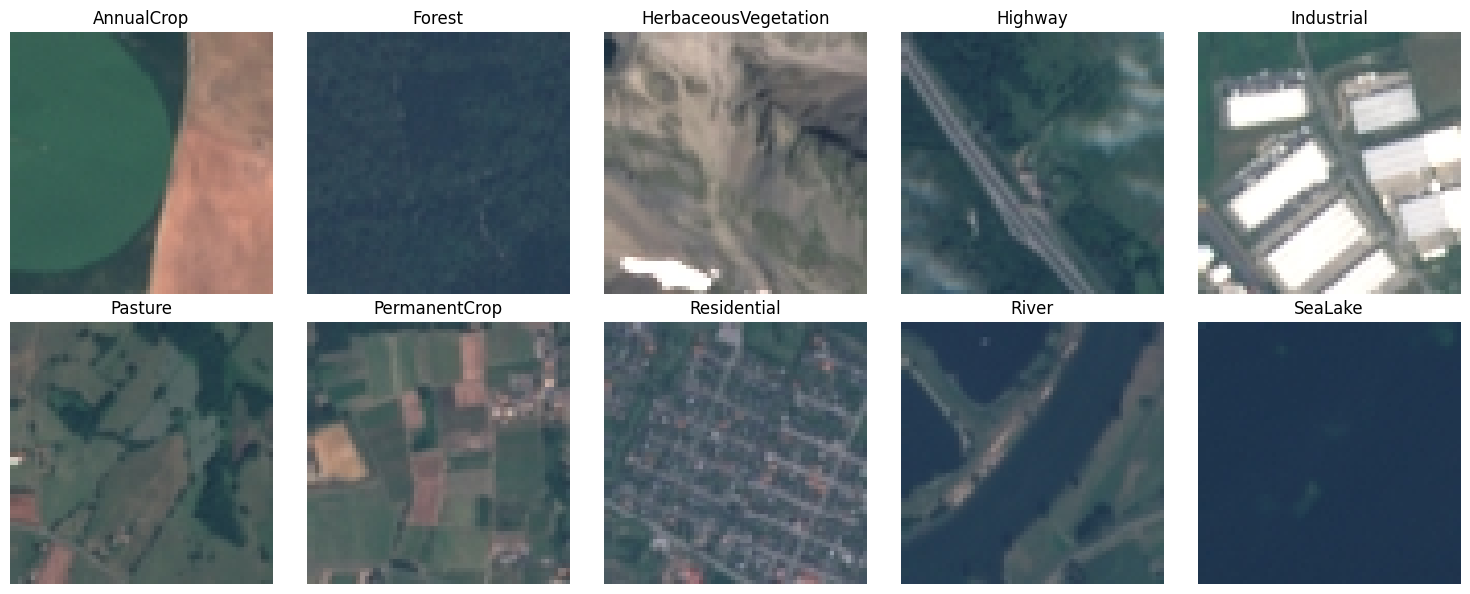

In [8]:
# Generate suplot figure (2 x 5) because there is 10 classes to plot just one image for each class
fig, axes = plt.subplots(2, 5, figsize=(15,6))

for i, class_name in enumerate(dataset.classes):
    class_path = os.path.join(dataset_path , class_name)
    image_files = os.listdir(class_path)
    img_path = os.path.join(class_path, image_files[1])


    # Create 2x5 subplot grid
    img = io.imread(img_path)

    ax = axes[i//5, i%5]
    ax.imshow(img)
    ax.set_title(f"{class_name}")
    ax.axis('off')

plt.tight_layout()
plt.show()
    

In [9]:
if os.path.exists(dataset_path):  # EuroSAT's folder
    dataset = torchvision.datasets.ImageFolder(root=dataset_path)
    dataset = ImageFolder(root=dataset_path)
    print("Image classes:", dataset.classes)
    print("Total images:", len(dataset))

Image classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Total images: 27000


## Open the Train , Test, and Validation CSV files

The dataset randomly divided into train (70%) , test (10%) and validation (20%) parts 


In [10]:
train_path = f"{dataset_path}/train.csv"
val_path = f"{dataset_path}/validation.csv"
test_path = f"{dataset_path}/test.csv"


In [11]:
df_train = pd.read_csv(train_path)
df_val = pd.read_csv(val_path)
df_test = pd.read_csv(test_path)


In [12]:
print(f" Number of Training Images : {len(df_train)} images")
print(f" Number of Validation Images: {len(df_val)} images")
print(f" Number of Testing Images : {len(df_test)} images")

 Number of Training Images : 18900 images
 Number of Validation Images: 5400 images
 Number of Testing Images : 2700 images


# Read the train, test and validation data

In [13]:
# Get the path of images that selected for train, test , or for validation

X_train = [os.path.join(dataset_path, filename) for filename in df_train["Filename"].values]
X_val = [os.path.join(dataset_path, filename) for filename in df_val["Filename"].values]
X_test = [os.path.join(dataset_path, filename) for filename in df_test["Filename"].values]

# Get Classname for each image

y_train = df_train["ClassName"].values  #  'ClassName' for labels
y_val = df_val["ClassName"].values
y_test = df_test["ClassName"].values

# Get label for each image

label_train = df_train["Label"].values  #  'Label' for each class
label_val = df_val["Label"].values
label_test = df_test["Label"].values


In [19]:
print(f" Number of training images : {len(X_train)}")
print(f" path of first train image : {X_train[0]}")

 Number of training images : 18900
 path of first train image : ./data/EuroSAT\AnnualCrop/AnnualCrop_142.jpg


C:\Users\10\AppData\Local\Temp\ipykernel_4352\1236698804.py:2: FutureWarning: `imshow` is deprecated since version 0.25 and will be removed in version 0.27. Please use `matplotlib`, `napari`, etc. to visualize images.
  io.imshow(img)


Image dimensions (shape): (64, 64, 3)
Image data type: uint8
Number of channels: 3
Min pixel value: 59
Max pixel value: 255


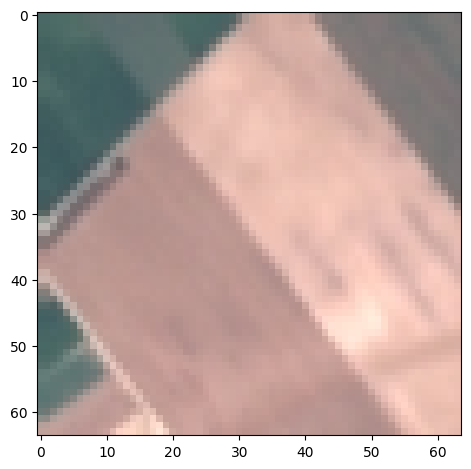

In [40]:
img = io.imread(X_train[0])
io.imshow(img)
# Print image properties
print("Image dimensions (shape):", img.shape)
print("Image data type:", img.dtype)
print("Number of channels:", img.shape[2] if len(img.shape) > 2 else 1)
print("Min pixel value:", np.min(img))
print("Max pixel value:", np.max(img))

## Data Exploration
- Summary statistics (mean, median, variance).
- Data distribution visualizations: histograms.

Visualizing sample images and histograms


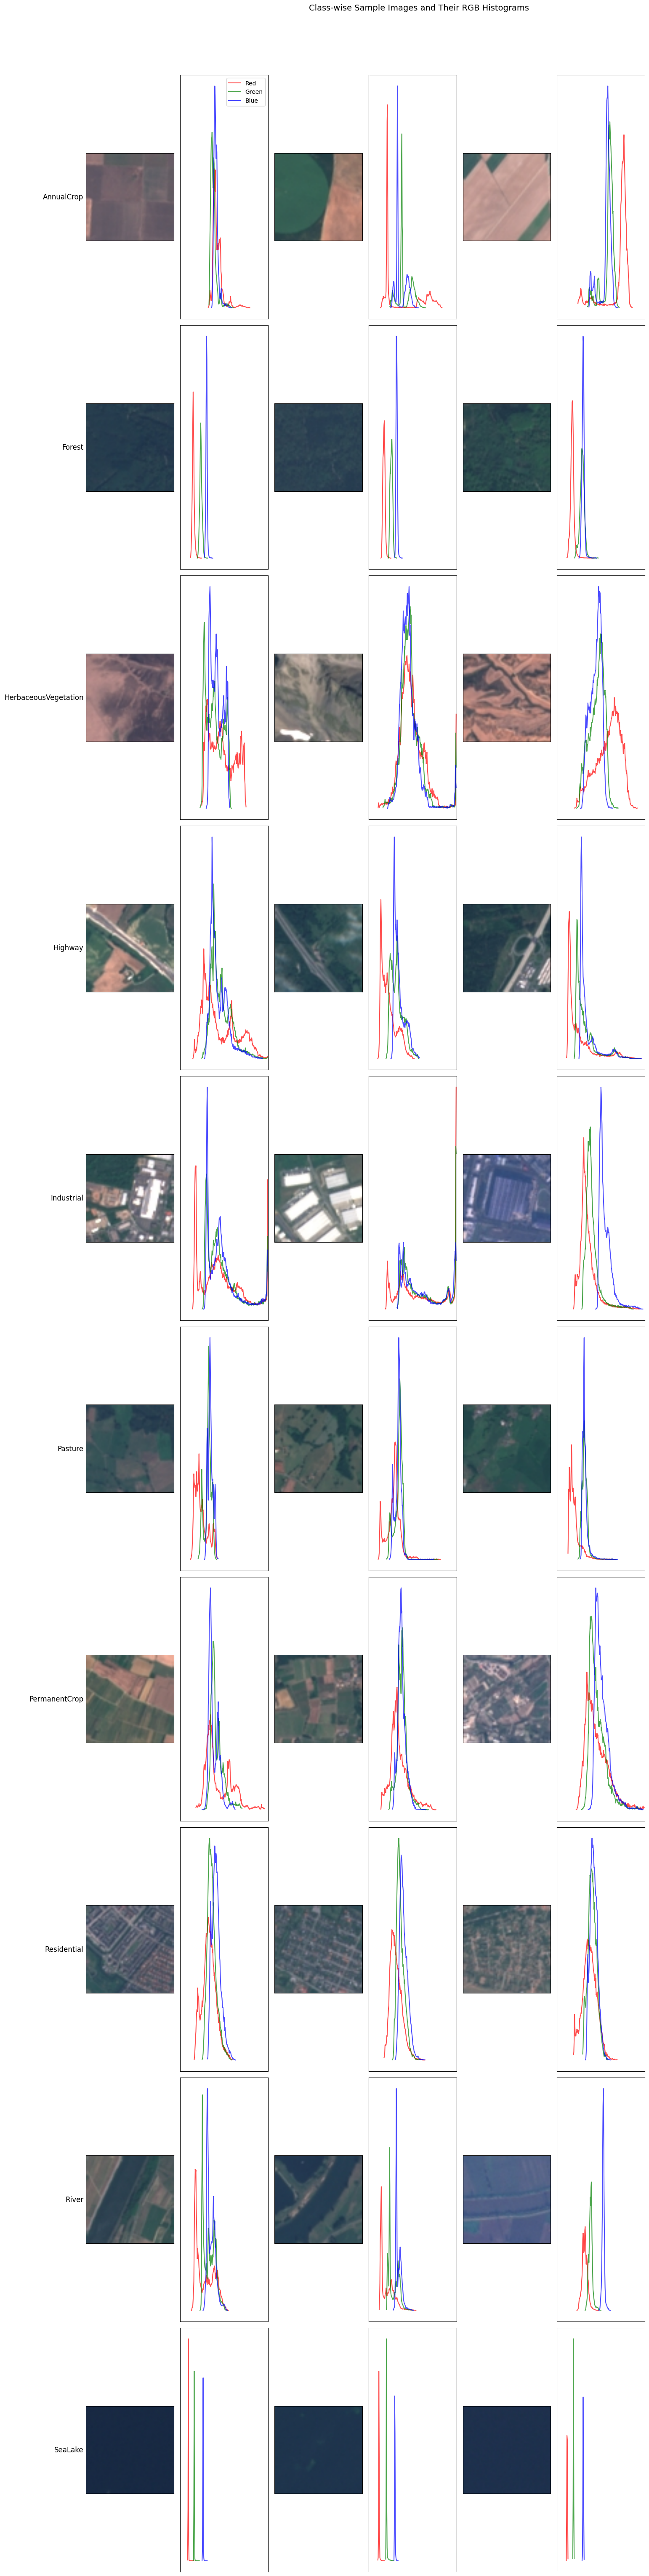


Calculating class statistics
Processing class 1/10: AnnualCrop
Processing class 2/10: Forest
Processing class 3/10: HerbaceousVegetation
Processing class 4/10: Highway
Processing class 5/10: Industrial
Processing class 6/10: Pasture
Processing class 7/10: PermanentCrop
Processing class 8/10: Residential
Processing class 9/10: River
Processing class 10/10: SeaLake

Class Statistics Summary:


,Class,Images,Mean,Std,Min,Median,Max
0,AnnualCrop,100,120.960187,39.856918,29,116.0,255
1,Forest,100,59.723414,17.544415,18,62.0,166
2,HerbaceousVegetation,100,101.120351,31.866697,23,95.0,255
3,Highway,100,96.160784,36.689500,21,91.0,255
4,Industrial,100,130.857802,49.747578,25,120.0,255
5,Pasture,100,80.240850,21.672136,21,82.0,255
6,PermanentCrop,100,115.042129,36.217475,28,109.0,255
7,Residential,100,102.136773,28.789537,8,98.0,255
8,River,100,83.431195,29.625365,21,82.0,255
9,SeaLake,100,66.840219,28.774154,18,69.0,255


<Figure size 640x480 with 0 Axes>

In [20]:
# Satellite Image Data Exploration 


SAMPLES_PER_CLASS = 3  # Number of sample images to show per class
IMG_SIZE = (256, 256)  # Size to resize images for consistent comparison

def plot_class_histograms(data_dir, classes, samples_per_class=3):
    """Plot sample images and their RGB histograms for each class"""
    plt.figure(figsize=(20, 6 * len(classes)))
    
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            print(f"Warning: {class_dir} not found. Skipping...")
            continue
            
        # Get sample images from this class
        img_files = [f for f in os.listdir(class_dir) 
                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))][:samples_per_class]
        
        for sample_idx, img_file in enumerate(img_files):
            img_path = os.path.join(class_dir, img_file)
            
            try:
                # Read and process image
                img = io.imread(img_path)
                if len(img.shape) == 2:  # Grayscale to RGB
                    img = color.gray2rgb(img)
                img = transform.resize(img, IMG_SIZE)
                img = (img * 255).astype(np.uint8)  # Convert to 0-255
                
                # Plot positions
                img_pos = class_idx * (samples_per_class + 1) * 2 + sample_idx * 2 + 1
                hist_pos = img_pos + 1
                
                # Plot sample image
                ax = plt.subplot(len(classes), (samples_per_class + 1) * 2, img_pos)
                plt.imshow(img)
                if sample_idx == 0:
                    plt.ylabel(class_name, rotation=0, ha='right', va='center', fontsize=12)
                plt.xticks([])
                plt.yticks([])
                
                # Plot RGB histogram
                ax = plt.subplot(len(classes), (samples_per_class + 1) * 2, hist_pos)
                for channel, color_name in enumerate(['red', 'green', 'blue']):
                    hist, bins = exposure.histogram(img[..., channel], nbins=256)
                    plt.plot(bins, hist, color=color_name, alpha=0.7, label=color_name.capitalize())
                
                plt.xlim([0, 256])
                plt.grid(True, alpha=0.3)
                plt.xticks([])
                plt.yticks([])
                if class_idx == 0 and sample_idx == 0:
                    plt.legend(loc='upper right')
            
            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
    
    plt.suptitle('Class-wise Sample Images and Their RGB Histograms', y=1.02, fontsize=14)
    plt.tight_layout()
    plt.show()

def generate_class_statistics(data_dir, classes):
    """Calculate basic statistics for each class (with print-based progress)"""
    stats = []
    
    for class_idx, class_name in enumerate(classes):
        print(f"Processing class {class_idx+1}/{len(classes)}: {class_name}")
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.exists(class_dir):
            continue
            
        pixel_values = []
        num_images = 0
        
        # Analyze first 100 images per class
        img_files = [f for f in os.listdir(class_dir) 
                    if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tif'))][:100]
        
        for img_file in img_files:
            img_path = os.path.join(class_dir, img_file)
            try:
                img = io.imread(img_path)
                if img is not None:
                    if len(img.shape) == 2:
                        img = color.gray2rgb(img)
                    pixel_values.extend(img.ravel())
                    num_images += 1
            except Exception as e:
                print(f"Error reading {img_path}: {str(e)}")
        
        if pixel_values:
            stats.append({
                'Class': class_name,
                'Images': num_images,
                'Mean': np.mean(pixel_values),
                'Std': np.std(pixel_values),
                'Min': np.min(pixel_values),
                'Median': np.median(pixel_values),
                'Max': np.max(pixel_values)
            })
    
    # Display as DataFrame
    df_stats = pd.DataFrame(stats)
    print("\nClass Statistics Summary:")
    display(df_stats)
    return df_stats


# Run the exploration
print("Visualizing sample images and histograms")
plot_class_histograms(dataset_path, dataset.classes, SAMPLES_PER_CLASS)

print("\nCalculating class statistics")
class_stats = generate_class_statistics(dataset_path, dataset.classes)

# Save results
class_stats.to_csv('class_statistics.csv', index=False)
plt.savefig('class_histograms.png', dpi=300, bbox_inches='tight')


---

# Milestone 2: Advanced Data Analysis and Feature Engineering

## Feature Engineering
- Create derived features based on domain knowledge.


In [70]:


def extract_advanced_features(image_path, bins=32, distances=[1], angles=[0]):
    """
    Extract comprehensive features from RGB images including:
    - Statistical features (mean, std, etc.)
    - HSV components
    - Color histograms
    - Texture features (GLCM)
    - RGB-based vegetation indices
    
    Args:
        image_path: Path to the RGB image (uint8)
        bins: Number of bins for histograms
        distances/angles: GLCM parameters
        
    Returns:
        Dictionary of features
    """
    # Load and validate image
    img = io.imread(image_path)
    if img.dtype != np.uint8:
        img = img_as_ubyte(img)
    R, G, B = img[..., 0], img[..., 1], img[..., 2]
    features = {}
    
    # ======================
    # 1. BASIC STATISTICS
    # ======================
    for channel, name in zip([R, G, B], ['red', 'green', 'blue']):
        features[f'{name}_mean'] = np.mean(channel)
        features[f'{name}_std'] = np.std(channel)
        features[f'{name}_median'] = np.median(channel)
        features[f'{name}_skew'] = pd.Series(channel.flatten()).skew()
    
    # ======================
    # 2. HSV STATISTICS
    # ======================
    hsv = color.rgb2hsv(img)
    for i, name in enumerate(['hue', 'saturation', 'value']):
        channel = hsv[..., i]
        features[f'{name}_mean'] = np.mean(channel)
        features[f'{name}_std'] = np.std(channel)
    
    # ======================
    # 3. COLOR HISTOGRAMS
    # ======================
    for i, name in enumerate(['red', 'green', 'blue']):
        hist = np.histogram(img[..., i], bins=bins, range=(0, 256))[0]
        hist = hist / hist.sum()  # Normalize
        for bin_idx in range(bins):
            features[f'{name}_hist_bin{bin_idx}'] = hist[bin_idx]
    
    # ======================
    # 4. TEXTURE (GLCM)
    # ======================
    gray = color.rgb2gray(img) * 255
    gray = gray.astype(np.uint8)
    glcm = graycomatrix(gray, distances=distances, angles=angles, levels=256)
    for prop in ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation']:
        features[f'glcm_{prop}'] = graycoprops(glcm, prop)[0, 0]
    
    # ======================
    # 5. VEGETATION INDICES
    # ======================
    # RGB-based approximations (no NIR available)
    features['vari'] = (G - R) / (G + R - B + 1e-10)  # Visible Atmospherically Resistant Index
    features['exg'] = 2*G - R - B  # Excess Green Index
    features['cive'] = 0.441*R - 0.811*G + 0.385*B + 18.787  # Color Index of Vegetation Extraction

    
    return features



In [98]:
# Extract train features (from first 1000 training images)


train_df = pd.DataFrame()

for i , img_path in enumerate(X_train[0:1000]):
    features = extract_advanced_features(img_path)
    train_df = pd.concat([train_df, pd.DataFrame([features])], ignore_index=True)


train_df.to_csv("train_features.csv", index=False)
print(f"Extracted {len(features)} features")
print(train_df.iloc[:, :10].head())  # Show first 10 columns



Extracted 122 features
     red_mean    red_std  red_median  red_skew  green_mean  green_std  \
0  181.677734  54.891910       192.0 -0.827775  155.484375  32.590825   
1   69.551270  11.813463        71.0 -0.405727   72.547607   8.297901   
2  139.982422  46.098243       122.0  0.757717  131.994141  29.214705   
3  123.945068  66.159045       101.0  0.869417  136.319824  55.172070   
4  136.734863  28.359844       131.5  1.026074  125.685303  22.559250   

   green_median  green_skew   blue_mean   blue_std  
0         154.0   -0.235908  148.836182  28.222085  
1          74.0   -0.615039   83.649902   5.898473  
2         126.0    1.036737  122.477295  26.020077  
3         116.0    1.109490  147.397705  51.108229  
4         121.0    1.400446  125.003662  19.299316  


In [81]:
print(len(train_df))

1000


In [80]:
# Extract validation features (from first 300 validation images)


val_df = pd.DataFrame()

for i , img_path in enumerate(X_val[0:300]):
    features = extract_advanced_features(img_path)
    val_df = pd.concat([val_df, pd.DataFrame([features])], ignore_index=True)


val_df.to_csv("validation_features.csv", index=False)
print(f"Extracted {len(features)} features")
print(val_df.iloc[:, :10].head())  # Show first 10 columns



Extracted 122 features
    red_mean    red_std  red_median  red_skew  green_mean  green_std  \
0  53.984131   9.570896        53.0  1.795128   84.359619  10.602979   
1  36.274170   2.869692        36.0  2.375823   62.029053   3.117943   
2  85.135986  38.147954        72.0  0.840070   98.548096  23.192998   
3  59.248779  22.093206        54.0  2.189083   82.214844  14.427697   
4  23.842773   0.699600        24.0 -0.826303   41.011719   0.742712   

   green_median  green_skew  blue_mean   blue_std  
0          85.0    0.152611  80.591553   6.461267  
1          62.0    1.419796  73.879150   2.015757  
2          98.0    0.716049  99.942871  19.355135  
3          83.0    1.483137  89.512451  10.729079  
4          41.0   -0.161813  66.682861   0.787946  


In [82]:
print(len(val_df))

300


In [83]:
# Extract test features (from first 300 testing images)


test_df = pd.DataFrame()

for i , img_path in enumerate(X_test[0:300]):
    features = extract_advanced_features(img_path)
    test_df = pd.concat([test_df, pd.DataFrame([features])], ignore_index=True)


test_df.to_csv("test_features.csv", index=False)
print(f"Extracted {len(features)} features")
print(test_df.iloc[:, :10].head())  # Show first 10 columns



Extracted 122 features
     red_mean    red_std  red_median  red_skew  green_mean  green_std  \
0   96.570312  20.642297        98.0  0.267079  109.161377   6.717448   
1   57.368164  17.424844        54.0  2.855286   76.935303  13.884462   
2   77.202148  21.494018        74.0  1.007226   99.119385  13.984703   
3  100.702393  23.882250        99.0  0.754039  107.301758  17.164836   
4   55.965820  17.196029        51.0  2.000845   85.387695   9.492009   

   green_median  green_skew   blue_mean   blue_std  
0         110.0   -0.092105  106.452637   7.696051  
1          74.5    2.420475   87.231445  12.678227  
2          97.0    1.191827   96.461426  10.778350  
3         105.0    1.487640  114.929932  16.714112  
4          84.0    2.309931   84.336426  10.366012  


In [84]:
print(len(test_df))

300


In [89]:
train_label = label_train[0:1000]

train_label_df = pd.DataFrame(train_label, columns=["label"])

val_label = label_val[0:300]

val_label_df = pd.DataFrame(val_label, columns=["label"])

test_label = label_test[0:300]

test_label_df = pd.DataFrame(test_label, columns=["label"])


In [99]:
print(train_df.head().to_dict())

{'red_mean': {0: 181.677734375, 1: 69.55126953125, 2: 139.982421875, 3: 123.945068359375, 4: 136.73486328125}, 'red_std': {0: 54.89190952047891, 1: 11.813463434157038, 2: 46.09824325127013, 3: 66.15904472792616, 4: 28.359844441377327}, 'red_median': {0: 192.0, 1: 71.0, 2: 122.0, 3: 101.0, 4: 131.5}, 'red_skew': {0: -0.8277753058013428, 1: -0.4057267934030869, 2: 0.7577172388608854, 3: 0.8694165722452688, 4: 1.0260740294461517}, 'green_mean': {0: 155.484375, 1: 72.547607421875, 2: 131.994140625, 3: 136.31982421875, 4: 125.685302734375}, 'green_std': {0: 32.590824862748946, 1: 8.297900662720808, 2: 29.21470501485895, 3: 55.17206977068742, 4: 22.559250086364422}, 'green_median': {0: 154.0, 1: 74.0, 2: 126.0, 3: 116.0, 4: 121.0}, 'green_skew': {0: -0.2359079531108196, 1: -0.6150390782757769, 2: 1.0367371369630871, 3: 1.1094902565555538, 4: 1.400445654394031}, 'blue_mean': {0: 148.836181640625, 1: 83.64990234375, 2: 122.477294921875, 3: 147.397705078125, 4: 125.003662109375}, 'blue_std': {0

## As noticed in the previous cell there is some column like (vari, exg, and cive ) contain (64 x 64 arrays), so we need to convert it to signle values (by summarizing its array to mean, std, min, and max values)

In [100]:

def summarize_array_column(df, column_name):
    df[f"{column_name}_mean"] = df[column_name].apply(np.mean)
    df[f"{column_name}_std"] = df[column_name].apply(np.std)
    df[f"{column_name}_min"] = df[column_name].apply(np.min)
    df[f"{column_name}_max"] = df[column_name].apply(np.max)
    return df.drop(column_name, axis=1)


array_columns = ['vari', 'exg', 'cive']

for col in array_columns:
    train_df = summarize_array_column(train_df, col)
    val_df = summarize_array_column(val_df, col)
    test_df = summarize_array_column(test_df, col)


print(train_df.head())

     red_mean    red_std  red_median  red_skew  green_mean  green_std  \
0  181.677734  54.891910       192.0 -0.827775  155.484375  32.590825   
1   69.551270  11.813463        71.0 -0.405727   72.547607   8.297901   
2  139.982422  46.098243       122.0  0.757717  131.994141  29.214705   
3  123.945068  66.159045       101.0  0.869417  136.319824  55.172070   
4  136.734863  28.359844       131.5  1.026074  125.685303  22.559250   

   green_median  green_skew   blue_mean   blue_std  ...  vari_min  \
0         154.0   -0.235908  148.836182  28.222085  ...       0.0   
1          74.0   -0.615039   83.649902   5.898473  ...       0.0   
2         126.0    1.036737  122.477295  26.020077  ...       0.0   
3         116.0    1.109490  147.397705  51.108229  ...       0.0   
4         121.0    1.400446  125.003662  19.299316  ...       0.0   

       vari_max    exg_mean     exg_std  exg_min  exg_max  cive_mean  \
0  2.180000e+12  191.517334   78.723816        0      255  30.110983   
1 

In [109]:
### Save Training , Validation, and Testing features after solving the last issues

dump(train_df, 'train_data.joblib')
dump(val_df, 'validation_data.joblib')
dump(test_df, 'test_data.joblib')

['test_data.joblib']

# Milestone 3: Machine Learning Model Development

In [111]:
# Scaling the training data before applying it to the SVM

scaler = StandardScaler()
train_df_scaled = scaler.fit_transform(train_df)

In [113]:
# Train SVM classifier
svm = SVC(kernel='rbf', C=10, gamma='scale')
svm.fit(train_df_scaled, train_label_df)

# Save the Scaler
dump(scaler, 'svm_scaler.joblib') 

# Scale validation/test data using the SAME scaler
val_df_scaled = scaler.transform(val_df)  # Only transform (don't fit!)
test_df_scaled = scaler.transform(test_df)  # Only transform (don't fit!)

# Evaluate
val_pred = svm.predict(val_df_scaled)
print("Validation Results:\n", classification_report(val_label_df, val_pred))

# Predict
test_pred = svm.predict(test_df_scaled)
print("Test Results:\n", classification_report(test_label_df, test_pred))



c:\Users\10\anaconda3\envs\depi_env\lib\site-packages\sklearn\utils\validation.py:1408: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Validation Results:
               precision    recall  f1-score   support

           0       0.72      0.87      0.79        30
           1       0.97      0.94      0.96        36
           2       0.66      0.77      0.71        30
           3       0.51      0.64      0.57        28
           4       0.83      0.86      0.84        22
           5       0.72      0.62      0.67        21
           6       0.82      0.64      0.72        36
           7       0.94      0.87      0.90        38
           8       0.75      0.60      0.67        30
           9       0.90      0.97      0.93        29

    accuracy                           0.78       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.79      0.78      0.78       300

Test Results:
               precision    recall  f1-score   support

           0       0.61      0.58      0.60        24
           1       0.90      0.97      0.94        38
           2       0.96      0.74      0.8

In [106]:

# Random Forest
rf = RandomForestClassifier(n_estimators=100)
rf.fit(train_df, train_label_df)

val_pred_rf = rf.predict(val_df)
print("RF Validation Results:\n", classification_report(val_label_df, val_pred_rf))

test_pred_rf = rf.predict(test_df)
print("RF testing Results:\n", classification_report(test_label_df, test_pred_rf))

c:\Users\10\anaconda3\envs\depi_env\lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RF Validation Results:
               precision    recall  f1-score   support

           0       0.85      0.97      0.91        30
           1       0.92      0.92      0.92        36
           2       0.73      0.63      0.68        30
           3       0.47      0.50      0.48        28
           4       0.76      0.86      0.81        22
           5       0.56      0.67      0.61        21
           6       0.74      0.64      0.69        36
           7       0.88      0.97      0.93        38
           8       0.77      0.57      0.65        30
           9       0.97      0.97      0.97        29

    accuracy                           0.78       300
   macro avg       0.76      0.77      0.76       300
weighted avg       0.78      0.78      0.77       300

RF testing Results:
               precision    recall  f1-score   support

           0       0.87      0.83      0.85        24
           1       0.86      0.95      0.90        38
           2       0.81      0.65

In [114]:
# Save SVM Model
dump(svm, 'svm_model.joblib')

# Save RF Model
dump(rf, 'rf_model.joblib')


['rf_model.joblib']

In [115]:
# Save Features Names
feature_names = train_df.columns.tolist()  # Get feature names from DataFrame
dump(feature_names, 'feature_names.joblib')  # Save separately

['feature_names.joblib']


---



---


# Milestone 4: Deployment and Monitoring

## Deployment
- Deploy the model as a REST API (Flask, FastAPI) or interactive dashboards (Streamlit, Dash).
- Host on cloud platforms (AWS, Azure, GCP) or local servers.